# Federated Learning + Linear Quantization for RESNET18 & CIFAR10

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import numpy as np
from tqdm import tqdm
import seaborn as sns
from fedlern.utils import *
from fedlern.train_utils import *
from fedlern.quant_utils import *
from fedlern.models.resnet_v2 import ResNet18

## Relevant Parameters

In [2]:
epoch = 10
rounds = 25
num_clients = 10
learning_rate = 0.1
momentum = 0.9
weight_decay = 1e-5
clients_sample_size = int(.3 * num_clients) # Use 30% of available clients
num_workers = 8
train_batch_size =128
eval_batch_size=256
quantize_bits = 3
stats = (0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)

## Data Loaders
- Divide the test & training data
- Divide the training data among the clients

In [3]:
 # Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# Normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test)

# split the training data
train_splits = torch.utils.data.random_split(train_dataset, [int(train_dataset.data.shape[0]/num_clients) for i in range(num_clients)])

# Data loaders
train_loaders = [DataLoader(dataset=split, batch_size=train_batch_size, shuffle=True, num_workers=num_workers) for split in train_splits]
test_loader = DataLoader(dataset=test_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=num_workers)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Files already downloaded and verified



- `server_aggregate` function aggregates the model weights received from every client and updates the global model with the updated weights.

In [4]:

def server_aggregate(global_model : torch.nn.Module, client_models):
    """
    The means of the weights of the client models are aggregated to the global model
    """
    global_dict = global_model.state_dict() # Get a copy of the global model state_dict
    for key in global_dict.keys():
        global_dict[key] = torch.stack([client_models[i].state_dict()[key].float() for i in range(len(client_models))],0).mean(0)
    global_model.load_state_dict(global_dict)
    
    # Update the client models using the global model
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

## Global & Clients instatiation
Implement the same elements as before, but:
- We need more instances of the model
- An optimizer for each model

In [5]:
global_model = ResNet18().to(device)
client_models = [ResNet18()
                     .to(device)
                     #.load_state_dict(global_model.state_dict())
                  for _ in range(num_clients)]



# criterion = nn.CrossEntropyLoss() # computes the cross-entropy loss between the predicted and true labels
# optimizers =[optim.Adam(model.parameters(), lr=0.001) for model in client_models]


In [6]:
# Optimizer & criterion based on gobal model
#global_optimizer = get_model_optimizer(global_model,
#                                       learning_rate=0.1,
#                                       weight_decay=5e-4)
global_optimizer = optim.SGD(global_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80,120,160], gamma=0.1)
criterion = nn.CrossEntropyLoss().to(device) # computes the cross-entropy loss between the predicted and true labels

#optimizers = [get_model_optimizer(model,learning_rate=0.1, weight_decay=5e-4) for model in client_models]
optimizers = [optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay) for model in client_models]

In [7]:
# initialize lists to store the training and testing losses and accuracies
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for round in tqdm(range(rounds)):


    # Select n random clients
    selected_clients = np.random.permutation(num_clients)[:clients_sample_size]
    # Train the selected clients
    for client in selected_clients:
        # Individual criterion and optimizer

        train_loss, train_acc = train_model(model = client_models[client],
                                             train_loader = train_loaders[client],
                                             device = device,
                                             criterion = criterion,
                                             optimizer = optimizers[client],
                                             num_epochs=epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Aggregate
    server_aggregate(global_model, client_models)

    # Test the global model
    test_loss, test_acc = evaluate_model(model=global_model,
                                         test_loader=test_loader,
                                         device=device,
                                         criterion=criterion)

    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f"{round}-th ROUND: average train loss {(train_loss / clients_sample_size):0.3g} | test loss {test_loss:0.3g} | test acc: {test_acc:0.3f}")
    
    

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0/10 Train Loss: 2.963 Train Acc: 0.160
Epoch: 1/10 Train Loss: 2.045 Train Acc: 0.206
Epoch: 2/10 Train Loss: 1.955 Train Acc: 0.244
Epoch: 3/10 Train Loss: 1.973 Train Acc: 0.243
Epoch: 4/10 Train Loss: 1.867 Train Acc: 0.283
Epoch: 5/10 Train Loss: 1.849 Train Acc: 0.291
Epoch: 6/10 Train Loss: 1.795 Train Acc: 0.322
Epoch: 7/10 Train Loss: 1.705 Train Acc: 0.353
Epoch: 8/10 Train Loss: 1.696 Train Acc: 0.346
Epoch: 9/10 Train Loss: 1.621 Train Acc: 0.389
Epoch: 0/10 Train Loss: 3.147 Train Acc: 0.146
Epoch: 1/10 Train Loss: 2.153 Train Acc: 0.189
Epoch: 2/10 Train Loss: 2.084 Train Acc: 0.216
Epoch: 3/10 Train Loss: 1.955 Train Acc: 0.253
Epoch: 4/10 Train Loss: 1.934 Train Acc: 0.264
Epoch: 5/10 Train Loss: 1.919 Train Acc: 0.280
Epoch: 6/10 Train Loss: 1.888 Train Acc: 0.292
Epoch: 7/10 Train Loss: 1.807 Train Acc: 0.311
Epoch: 8/10 Train Loss: 1.787 Train Acc: 0.313
Epoch: 9/10 Train Loss: 1.766 Train Acc: 0.334
Epoch: 0/10 Train Loss: 3.649 Train Acc: 0.112
Epoch: 1/10 T

  4%|▍         | 1/25 [00:53<21:24, 53.52s/it]

0-th ROUND: average train loss 0.596 | test loss 2.31 | test acc: 0.100
Epoch: 0/10 Train Loss: 2.085 Train Acc: 0.208
Epoch: 1/10 Train Loss: 1.945 Train Acc: 0.251
Epoch: 2/10 Train Loss: 1.938 Train Acc: 0.251
Epoch: 3/10 Train Loss: 1.812 Train Acc: 0.291
Epoch: 4/10 Train Loss: 1.828 Train Acc: 0.297
Epoch: 5/10 Train Loss: 1.709 Train Acc: 0.341
Epoch: 6/10 Train Loss: 1.764 Train Acc: 0.339
Epoch: 7/10 Train Loss: 1.697 Train Acc: 0.356
Epoch: 8/10 Train Loss: 1.607 Train Acc: 0.393
Epoch: 9/10 Train Loss: 1.602 Train Acc: 0.392
Epoch: 0/10 Train Loss: 2.105 Train Acc: 0.197
Epoch: 1/10 Train Loss: 1.952 Train Acc: 0.264
Epoch: 2/10 Train Loss: 1.940 Train Acc: 0.269
Epoch: 3/10 Train Loss: 1.853 Train Acc: 0.287
Epoch: 4/10 Train Loss: 1.826 Train Acc: 0.314
Epoch: 5/10 Train Loss: 1.776 Train Acc: 0.330
Epoch: 6/10 Train Loss: 1.697 Train Acc: 0.359
Epoch: 7/10 Train Loss: 1.841 Train Acc: 0.318
Epoch: 8/10 Train Loss: 1.735 Train Acc: 0.352
Epoch: 9/10 Train Loss: 1.673 Train

  8%|▊         | 2/25 [01:54<22:15, 58.08s/it]

1-th ROUND: average train loss 0.555 | test loss 2.31 | test acc: 0.100
Epoch: 0/10 Train Loss: 1.891 Train Acc: 0.290
Epoch: 1/10 Train Loss: 1.893 Train Acc: 0.293
Epoch: 2/10 Train Loss: 1.980 Train Acc: 0.264
Epoch: 3/10 Train Loss: 1.888 Train Acc: 0.275
Epoch: 4/10 Train Loss: 1.744 Train Acc: 0.325
Epoch: 5/10 Train Loss: 1.679 Train Acc: 0.363
Epoch: 6/10 Train Loss: 1.914 Train Acc: 0.273
Epoch: 7/10 Train Loss: 1.722 Train Acc: 0.334
Epoch: 8/10 Train Loss: 1.671 Train Acc: 0.375
Epoch: 9/10 Train Loss: 1.620 Train Acc: 0.391
Epoch: 0/10 Train Loss: 1.857 Train Acc: 0.305
Epoch: 1/10 Train Loss: 1.937 Train Acc: 0.284
Epoch: 2/10 Train Loss: 1.732 Train Acc: 0.346
Epoch: 3/10 Train Loss: 1.715 Train Acc: 0.361
Epoch: 4/10 Train Loss: 1.637 Train Acc: 0.391
Epoch: 5/10 Train Loss: 1.630 Train Acc: 0.391
Epoch: 6/10 Train Loss: 1.544 Train Acc: 0.424
Epoch: 7/10 Train Loss: 1.523 Train Acc: 0.442
Epoch: 8/10 Train Loss: 1.650 Train Acc: 0.386
Epoch: 9/10 Train Loss: 1.477 Train

 12%|█▏        | 3/25 [02:50<20:56, 57.11s/it]

2-th ROUND: average train loss 0.501 | test loss 2.32 | test acc: 0.100
Epoch: 0/10 Train Loss: 1.658 Train Acc: 0.373
Epoch: 1/10 Train Loss: 1.716 Train Acc: 0.364
Epoch: 2/10 Train Loss: 1.694 Train Acc: 0.365
Epoch: 3/10 Train Loss: 1.567 Train Acc: 0.408
Epoch: 4/10 Train Loss: 1.504 Train Acc: 0.440
Epoch: 5/10 Train Loss: 1.433 Train Acc: 0.469
Epoch: 6/10 Train Loss: 1.522 Train Acc: 0.435
Epoch: 7/10 Train Loss: 1.433 Train Acc: 0.477
Epoch: 8/10 Train Loss: 1.357 Train Acc: 0.499
Epoch: 9/10 Train Loss: 1.418 Train Acc: 0.473
Epoch: 0/10 Train Loss: 1.693 Train Acc: 0.372
Epoch: 1/10 Train Loss: 1.720 Train Acc: 0.353
Epoch: 2/10 Train Loss: 1.651 Train Acc: 0.384
Epoch: 3/10 Train Loss: 1.673 Train Acc: 0.378
Epoch: 4/10 Train Loss: 1.653 Train Acc: 0.402
Epoch: 5/10 Train Loss: 1.530 Train Acc: 0.437
Epoch: 6/10 Train Loss: 1.487 Train Acc: 0.441
Epoch: 7/10 Train Loss: 1.427 Train Acc: 0.479
Epoch: 8/10 Train Loss: 1.387 Train Acc: 0.489
Epoch: 9/10 Train Loss: 1.366 Train

 16%|█▌        | 4/25 [03:50<20:18, 58.04s/it]

3-th ROUND: average train loss 0.485 | test loss 2.32 | test acc: 0.100
Epoch: 0/10 Train Loss: 1.613 Train Acc: 0.401
Epoch: 1/10 Train Loss: 1.610 Train Acc: 0.392
Epoch: 2/10 Train Loss: 1.494 Train Acc: 0.440
Epoch: 3/10 Train Loss: 1.517 Train Acc: 0.442
Epoch: 4/10 Train Loss: 1.486 Train Acc: 0.446
Epoch: 5/10 Train Loss: 1.351 Train Acc: 0.503
Epoch: 6/10 Train Loss: 1.358 Train Acc: 0.506
Epoch: 7/10 Train Loss: 1.292 Train Acc: 0.534
Epoch: 8/10 Train Loss: 1.296 Train Acc: 0.539
Epoch: 9/10 Train Loss: 1.289 Train Acc: 0.526
Epoch: 0/10 Train Loss: 1.532 Train Acc: 0.429
Epoch: 1/10 Train Loss: 1.517 Train Acc: 0.428
Epoch: 2/10 Train Loss: 1.455 Train Acc: 0.449
Epoch: 3/10 Train Loss: 1.452 Train Acc: 0.454
Epoch: 4/10 Train Loss: 1.431 Train Acc: 0.468
Epoch: 5/10 Train Loss: 1.444 Train Acc: 0.458
Epoch: 6/10 Train Loss: 1.487 Train Acc: 0.453
Epoch: 7/10 Train Loss: 1.328 Train Acc: 0.504
Epoch: 8/10 Train Loss: 1.369 Train Acc: 0.490
Epoch: 9/10 Train Loss: 1.295 Train

 20%|██        | 5/25 [04:49<19:29, 58.46s/it]

4-th ROUND: average train loss 0.455 | test loss 2.35 | test acc: 0.107
Epoch: 0/10 Train Loss: 1.426 Train Acc: 0.481
Epoch: 1/10 Train Loss: 1.490 Train Acc: 0.454
Epoch: 2/10 Train Loss: 1.355 Train Acc: 0.507
Epoch: 3/10 Train Loss: 1.385 Train Acc: 0.494
Epoch: 4/10 Train Loss: 1.268 Train Acc: 0.539
Epoch: 5/10 Train Loss: 1.304 Train Acc: 0.513
Epoch: 6/10 Train Loss: 1.212 Train Acc: 0.556
Epoch: 7/10 Train Loss: 1.284 Train Acc: 0.532
Epoch: 8/10 Train Loss: 1.151 Train Acc: 0.586
Epoch: 9/10 Train Loss: 1.131 Train Acc: 0.595
Epoch: 0/10 Train Loss: 1.397 Train Acc: 0.485
Epoch: 1/10 Train Loss: 1.480 Train Acc: 0.452
Epoch: 2/10 Train Loss: 1.396 Train Acc: 0.495
Epoch: 3/10 Train Loss: 1.415 Train Acc: 0.472
Epoch: 4/10 Train Loss: 1.332 Train Acc: 0.513
Epoch: 5/10 Train Loss: 1.326 Train Acc: 0.527
Epoch: 6/10 Train Loss: 1.232 Train Acc: 0.553
Epoch: 7/10 Train Loss: 1.252 Train Acc: 0.546
Epoch: 8/10 Train Loss: 1.216 Train Acc: 0.563
Epoch: 9/10 Train Loss: 1.156 Train

 24%|██▍       | 6/25 [05:46<18:23, 58.08s/it]

5-th ROUND: average train loss 0.382 | test loss 2.43 | test acc: 0.172
Epoch: 0/10 Train Loss: 1.328 Train Acc: 0.517
Epoch: 1/10 Train Loss: 1.343 Train Acc: 0.519
Epoch: 2/10 Train Loss: 1.212 Train Acc: 0.562
Epoch: 3/10 Train Loss: 1.156 Train Acc: 0.585
Epoch: 4/10 Train Loss: 1.299 Train Acc: 0.535
Epoch: 5/10 Train Loss: 1.244 Train Acc: 0.558
Epoch: 6/10 Train Loss: 1.102 Train Acc: 0.611
Epoch: 7/10 Train Loss: 1.086 Train Acc: 0.611
Epoch: 8/10 Train Loss: 1.022 Train Acc: 0.635
Epoch: 9/10 Train Loss: 1.034 Train Acc: 0.631
Epoch: 0/10 Train Loss: 1.321 Train Acc: 0.523
Epoch: 1/10 Train Loss: 1.366 Train Acc: 0.502
Epoch: 2/10 Train Loss: 1.287 Train Acc: 0.534
Epoch: 3/10 Train Loss: 1.216 Train Acc: 0.565
Epoch: 4/10 Train Loss: 1.221 Train Acc: 0.565
Epoch: 5/10 Train Loss: 1.213 Train Acc: 0.573
Epoch: 6/10 Train Loss: 1.064 Train Acc: 0.617
Epoch: 7/10 Train Loss: 1.075 Train Acc: 0.618
Epoch: 8/10 Train Loss: 1.062 Train Acc: 0.628
Epoch: 9/10 Train Loss: 1.013 Train

 28%|██▊       | 7/25 [06:49<17:51, 59.53s/it]

6-th ROUND: average train loss 0.353 | test loss 2.39 | test acc: 0.208
Epoch: 0/10 Train Loss: 1.193 Train Acc: 0.572
Epoch: 1/10 Train Loss: 1.212 Train Acc: 0.561
Epoch: 2/10 Train Loss: 1.249 Train Acc: 0.549
Epoch: 3/10 Train Loss: 1.136 Train Acc: 0.592
Epoch: 4/10 Train Loss: 1.144 Train Acc: 0.594
Epoch: 5/10 Train Loss: 1.025 Train Acc: 0.633
Epoch: 6/10 Train Loss: 0.973 Train Acc: 0.651
Epoch: 7/10 Train Loss: 0.937 Train Acc: 0.666
Epoch: 8/10 Train Loss: 0.959 Train Acc: 0.657
Epoch: 9/10 Train Loss: 0.886 Train Acc: 0.688
Epoch: 0/10 Train Loss: 1.164 Train Acc: 0.584
Epoch: 1/10 Train Loss: 1.218 Train Acc: 0.570
Epoch: 2/10 Train Loss: 1.109 Train Acc: 0.603
Epoch: 3/10 Train Loss: 1.391 Train Acc: 0.495
Epoch: 4/10 Train Loss: 1.166 Train Acc: 0.576
Epoch: 5/10 Train Loss: 1.105 Train Acc: 0.595
Epoch: 6/10 Train Loss: 1.029 Train Acc: 0.633
Epoch: 7/10 Train Loss: 1.017 Train Acc: 0.628
Epoch: 8/10 Train Loss: 0.941 Train Acc: 0.654
Epoch: 9/10 Train Loss: 1.205 Train

 32%|███▏      | 8/25 [07:49<16:55, 59.75s/it]

7-th ROUND: average train loss 0.321 | test loss 2.17 | test acc: 0.280
Epoch: 0/10 Train Loss: 1.126 Train Acc: 0.597
Epoch: 1/10 Train Loss: 1.170 Train Acc: 0.575
Epoch: 2/10 Train Loss: 1.224 Train Acc: 0.561
Epoch: 3/10 Train Loss: 1.062 Train Acc: 0.618
Epoch: 4/10 Train Loss: 1.045 Train Acc: 0.626
Epoch: 5/10 Train Loss: 0.981 Train Acc: 0.639
Epoch: 6/10 Train Loss: 1.045 Train Acc: 0.630
Epoch: 7/10 Train Loss: 1.033 Train Acc: 0.629
Epoch: 8/10 Train Loss: 0.944 Train Acc: 0.666
Epoch: 9/10 Train Loss: 0.919 Train Acc: 0.675
Epoch: 0/10 Train Loss: 1.168 Train Acc: 0.576
Epoch: 1/10 Train Loss: 1.162 Train Acc: 0.589
Epoch: 2/10 Train Loss: 1.036 Train Acc: 0.628
Epoch: 3/10 Train Loss: 1.103 Train Acc: 0.612
Epoch: 4/10 Train Loss: 1.011 Train Acc: 0.633
Epoch: 5/10 Train Loss: 0.973 Train Acc: 0.651
Epoch: 6/10 Train Loss: 0.990 Train Acc: 0.651
Epoch: 7/10 Train Loss: 0.894 Train Acc: 0.679
Epoch: 8/10 Train Loss: 0.857 Train Acc: 0.691
Epoch: 9/10 Train Loss: 0.871 Train

 36%|███▌      | 9/25 [08:52<16:10, 60.66s/it]

8-th ROUND: average train loss 0.302 | test loss 1.74 | test acc: 0.411
Epoch: 0/10 Train Loss: 1.036 Train Acc: 0.631
Epoch: 1/10 Train Loss: 1.086 Train Acc: 0.611
Epoch: 2/10 Train Loss: 0.956 Train Acc: 0.661
Epoch: 3/10 Train Loss: 1.180 Train Acc: 0.585
Epoch: 4/10 Train Loss: 1.004 Train Acc: 0.639
Epoch: 5/10 Train Loss: 0.972 Train Acc: 0.654
Epoch: 6/10 Train Loss: 0.858 Train Acc: 0.688
Epoch: 7/10 Train Loss: 0.806 Train Acc: 0.707
Epoch: 8/10 Train Loss: 0.810 Train Acc: 0.712
Epoch: 9/10 Train Loss: 0.814 Train Acc: 0.709
Epoch: 0/10 Train Loss: 0.971 Train Acc: 0.661
Epoch: 1/10 Train Loss: 0.952 Train Acc: 0.658
Epoch: 2/10 Train Loss: 1.070 Train Acc: 0.618
Epoch: 3/10 Train Loss: 0.926 Train Acc: 0.667
Epoch: 4/10 Train Loss: 0.865 Train Acc: 0.695
Epoch: 5/10 Train Loss: 0.867 Train Acc: 0.693
Epoch: 6/10 Train Loss: 0.856 Train Acc: 0.691
Epoch: 7/10 Train Loss: 0.804 Train Acc: 0.704
Epoch: 8/10 Train Loss: 0.816 Train Acc: 0.707
Epoch: 9/10 Train Loss: 0.759 Train

 40%|████      | 10/25 [09:55<15:20, 61.39s/it]

9-th ROUND: average train loss 0.326 | test loss 1.46 | test acc: 0.512
Epoch: 0/10 Train Loss: 0.982 Train Acc: 0.647
Epoch: 1/10 Train Loss: 0.964 Train Acc: 0.653
Epoch: 2/10 Train Loss: 0.989 Train Acc: 0.642
Epoch: 3/10 Train Loss: 0.909 Train Acc: 0.678
Epoch: 4/10 Train Loss: 0.885 Train Acc: 0.679
Epoch: 5/10 Train Loss: 0.919 Train Acc: 0.664
Epoch: 6/10 Train Loss: 0.877 Train Acc: 0.685
Epoch: 7/10 Train Loss: 0.798 Train Acc: 0.712
Epoch: 8/10 Train Loss: 0.812 Train Acc: 0.704
Epoch: 9/10 Train Loss: 0.779 Train Acc: 0.718
Epoch: 0/10 Train Loss: 0.956 Train Acc: 0.657
Epoch: 1/10 Train Loss: 0.930 Train Acc: 0.667
Epoch: 2/10 Train Loss: 1.033 Train Acc: 0.636
Epoch: 3/10 Train Loss: 1.013 Train Acc: 0.637
Epoch: 4/10 Train Loss: 1.011 Train Acc: 0.644
Epoch: 5/10 Train Loss: 0.968 Train Acc: 0.655
Epoch: 6/10 Train Loss: 0.827 Train Acc: 0.703
Epoch: 7/10 Train Loss: 0.820 Train Acc: 0.704
Epoch: 8/10 Train Loss: 0.839 Train Acc: 0.702
Epoch: 9/10 Train Loss: 0.753 Train

 44%|████▍     | 11/25 [10:56<14:20, 61.44s/it]

10-th ROUND: average train loss 0.255 | test loss 1.26 | test acc: 0.575
Epoch: 0/10 Train Loss: 0.825 Train Acc: 0.707
Epoch: 1/10 Train Loss: 0.829 Train Acc: 0.705
Epoch: 2/10 Train Loss: 0.942 Train Acc: 0.672
Epoch: 3/10 Train Loss: 0.780 Train Acc: 0.717
Epoch: 4/10 Train Loss: 0.786 Train Acc: 0.721
Epoch: 5/10 Train Loss: 0.740 Train Acc: 0.732
Epoch: 6/10 Train Loss: 0.708 Train Acc: 0.748
Epoch: 7/10 Train Loss: 0.742 Train Acc: 0.736
Epoch: 8/10 Train Loss: 0.824 Train Acc: 0.701
Epoch: 9/10 Train Loss: 0.821 Train Acc: 0.707
Epoch: 0/10 Train Loss: 0.951 Train Acc: 0.664
Epoch: 1/10 Train Loss: 1.007 Train Acc: 0.652
Epoch: 2/10 Train Loss: 0.962 Train Acc: 0.659
Epoch: 3/10 Train Loss: 0.831 Train Acc: 0.706
Epoch: 4/10 Train Loss: 0.790 Train Acc: 0.720
Epoch: 5/10 Train Loss: 0.760 Train Acc: 0.732
Epoch: 6/10 Train Loss: 0.765 Train Acc: 0.737
Epoch: 7/10 Train Loss: 0.702 Train Acc: 0.750
Epoch: 8/10 Train Loss: 0.746 Train Acc: 0.731
Epoch: 9/10 Train Loss: 0.764 Trai

 48%|████▊     | 12/25 [11:59<13:25, 61.98s/it]

11-th ROUND: average train loss 0.217 | test loss 1.09 | test acc: 0.635
Epoch: 0/10 Train Loss: 0.870 Train Acc: 0.697
Epoch: 1/10 Train Loss: 0.899 Train Acc: 0.677
Epoch: 2/10 Train Loss: 0.821 Train Acc: 0.716
Epoch: 3/10 Train Loss: 0.810 Train Acc: 0.714
Epoch: 4/10 Train Loss: 0.746 Train Acc: 0.734
Epoch: 5/10 Train Loss: 0.713 Train Acc: 0.747
Epoch: 6/10 Train Loss: 0.832 Train Acc: 0.705
Epoch: 7/10 Train Loss: 0.743 Train Acc: 0.734
Epoch: 8/10 Train Loss: 0.771 Train Acc: 0.727
Epoch: 9/10 Train Loss: 0.774 Train Acc: 0.725
Epoch: 0/10 Train Loss: 0.870 Train Acc: 0.689
Epoch: 1/10 Train Loss: 0.866 Train Acc: 0.694
Epoch: 2/10 Train Loss: 0.876 Train Acc: 0.693
Epoch: 3/10 Train Loss: 0.816 Train Acc: 0.702
Epoch: 4/10 Train Loss: 0.766 Train Acc: 0.723
Epoch: 5/10 Train Loss: 0.833 Train Acc: 0.710
Epoch: 6/10 Train Loss: 0.685 Train Acc: 0.758
Epoch: 7/10 Train Loss: 0.731 Train Acc: 0.744
Epoch: 8/10 Train Loss: 0.719 Train Acc: 0.751
Epoch: 9/10 Train Loss: 0.627 Trai

 52%|█████▏    | 13/25 [13:00<12:17, 61.48s/it]

12-th ROUND: average train loss 0.209 | test loss 0.937 | test acc: 0.681
Epoch: 0/10 Train Loss: 0.822 Train Acc: 0.709
Epoch: 1/10 Train Loss: 0.861 Train Acc: 0.702
Epoch: 2/10 Train Loss: 0.832 Train Acc: 0.708
Epoch: 3/10 Train Loss: 0.942 Train Acc: 0.671
Epoch: 4/10 Train Loss: 0.755 Train Acc: 0.732
Epoch: 5/10 Train Loss: 0.736 Train Acc: 0.741
Epoch: 6/10 Train Loss: 0.685 Train Acc: 0.755
Epoch: 7/10 Train Loss: 0.710 Train Acc: 0.748
Epoch: 8/10 Train Loss: 0.617 Train Acc: 0.776
Epoch: 9/10 Train Loss: 0.683 Train Acc: 0.756
Epoch: 0/10 Train Loss: 0.806 Train Acc: 0.714
Epoch: 1/10 Train Loss: 0.797 Train Acc: 0.721
Epoch: 2/10 Train Loss: 0.857 Train Acc: 0.696
Epoch: 3/10 Train Loss: 0.713 Train Acc: 0.744
Epoch: 4/10 Train Loss: 0.698 Train Acc: 0.749
Epoch: 5/10 Train Loss: 0.614 Train Acc: 0.785
Epoch: 6/10 Train Loss: 0.652 Train Acc: 0.770
Epoch: 7/10 Train Loss: 0.610 Train Acc: 0.785
Epoch: 8/10 Train Loss: 0.590 Train Acc: 0.789
Epoch: 9/10 Train Loss: 0.674 Tra

 56%|█████▌    | 14/25 [14:00<11:12, 61.13s/it]

13-th ROUND: average train loss 0.214 | test loss 0.849 | test acc: 0.713
Epoch: 0/10 Train Loss: 0.710 Train Acc: 0.754
Epoch: 1/10 Train Loss: 0.770 Train Acc: 0.725
Epoch: 2/10 Train Loss: 0.688 Train Acc: 0.763
Epoch: 3/10 Train Loss: 0.692 Train Acc: 0.756
Epoch: 4/10 Train Loss: 0.699 Train Acc: 0.751
Epoch: 5/10 Train Loss: 0.633 Train Acc: 0.778
Epoch: 6/10 Train Loss: 0.563 Train Acc: 0.801
Epoch: 7/10 Train Loss: 0.682 Train Acc: 0.762
Epoch: 8/10 Train Loss: 0.561 Train Acc: 0.808
Epoch: 9/10 Train Loss: 0.599 Train Acc: 0.787
Epoch: 0/10 Train Loss: 0.736 Train Acc: 0.740
Epoch: 1/10 Train Loss: 0.706 Train Acc: 0.747
Epoch: 2/10 Train Loss: 0.793 Train Acc: 0.725
Epoch: 3/10 Train Loss: 0.660 Train Acc: 0.767
Epoch: 4/10 Train Loss: 0.681 Train Acc: 0.761
Epoch: 5/10 Train Loss: 0.627 Train Acc: 0.781
Epoch: 6/10 Train Loss: 0.619 Train Acc: 0.778
Epoch: 7/10 Train Loss: 0.658 Train Acc: 0.775
Epoch: 8/10 Train Loss: 0.606 Train Acc: 0.791
Epoch: 9/10 Train Loss: 0.511 Tra

 60%|██████    | 15/25 [15:00<10:08, 60.83s/it]

14-th ROUND: average train loss 0.174 | test loss 0.776 | test acc: 0.736
Epoch: 0/10 Train Loss: 0.701 Train Acc: 0.754
Epoch: 1/10 Train Loss: 0.711 Train Acc: 0.752
Epoch: 2/10 Train Loss: 0.672 Train Acc: 0.768
Epoch: 3/10 Train Loss: 0.793 Train Acc: 0.724
Epoch: 4/10 Train Loss: 0.675 Train Acc: 0.763
Epoch: 5/10 Train Loss: 0.586 Train Acc: 0.799
Epoch: 6/10 Train Loss: 0.542 Train Acc: 0.807
Epoch: 7/10 Train Loss: 0.611 Train Acc: 0.786
Epoch: 8/10 Train Loss: 0.557 Train Acc: 0.803
Epoch: 9/10 Train Loss: 0.534 Train Acc: 0.810
Epoch: 0/10 Train Loss: 0.717 Train Acc: 0.750
Epoch: 1/10 Train Loss: 0.792 Train Acc: 0.717
Epoch: 2/10 Train Loss: 0.648 Train Acc: 0.766
Epoch: 3/10 Train Loss: 0.662 Train Acc: 0.768
Epoch: 4/10 Train Loss: 0.587 Train Acc: 0.784
Epoch: 5/10 Train Loss: 0.668 Train Acc: 0.766
Epoch: 6/10 Train Loss: 0.600 Train Acc: 0.786
Epoch: 7/10 Train Loss: 0.531 Train Acc: 0.813
Epoch: 8/10 Train Loss: 0.546 Train Acc: 0.806
Epoch: 9/10 Train Loss: 0.505 Tra

 64%|██████▍   | 16/25 [16:01<09:06, 60.69s/it]

15-th ROUND: average train loss 0.154 | test loss 0.709 | test acc: 0.759
Epoch: 0/10 Train Loss: 0.672 Train Acc: 0.766
Epoch: 1/10 Train Loss: 0.625 Train Acc: 0.780
Epoch: 2/10 Train Loss: 0.611 Train Acc: 0.784
Epoch: 3/10 Train Loss: 0.662 Train Acc: 0.766
Epoch: 4/10 Train Loss: 0.603 Train Acc: 0.783
Epoch: 5/10 Train Loss: 0.565 Train Acc: 0.799
Epoch: 6/10 Train Loss: 0.533 Train Acc: 0.812
Epoch: 7/10 Train Loss: 0.544 Train Acc: 0.803
Epoch: 8/10 Train Loss: 0.500 Train Acc: 0.824
Epoch: 9/10 Train Loss: 0.483 Train Acc: 0.829
Epoch: 0/10 Train Loss: 0.695 Train Acc: 0.764
Epoch: 1/10 Train Loss: 0.671 Train Acc: 0.766
Epoch: 2/10 Train Loss: 0.635 Train Acc: 0.781
Epoch: 3/10 Train Loss: 0.591 Train Acc: 0.791
Epoch: 4/10 Train Loss: 0.579 Train Acc: 0.796
Epoch: 5/10 Train Loss: 0.500 Train Acc: 0.821
Epoch: 6/10 Train Loss: 0.525 Train Acc: 0.813
Epoch: 7/10 Train Loss: 0.537 Train Acc: 0.811
Epoch: 8/10 Train Loss: 0.449 Train Acc: 0.843
Epoch: 9/10 Train Loss: 0.426 Tra

 68%|██████▊   | 17/25 [17:02<08:06, 60.82s/it]

16-th ROUND: average train loss 0.181 | test loss 0.66 | test acc: 0.776
Epoch: 0/10 Train Loss: 0.587 Train Acc: 0.790
Epoch: 1/10 Train Loss: 0.569 Train Acc: 0.802
Epoch: 2/10 Train Loss: 0.540 Train Acc: 0.811
Epoch: 3/10 Train Loss: 0.516 Train Acc: 0.816
Epoch: 4/10 Train Loss: 0.465 Train Acc: 0.834
Epoch: 5/10 Train Loss: 0.562 Train Acc: 0.804
Epoch: 6/10 Train Loss: 0.454 Train Acc: 0.827
Epoch: 7/10 Train Loss: 0.598 Train Acc: 0.790
Epoch: 8/10 Train Loss: 0.463 Train Acc: 0.835
Epoch: 9/10 Train Loss: 0.508 Train Acc: 0.819
Epoch: 0/10 Train Loss: 0.678 Train Acc: 0.766
Epoch: 1/10 Train Loss: 0.627 Train Acc: 0.775
Epoch: 2/10 Train Loss: 0.701 Train Acc: 0.756
Epoch: 3/10 Train Loss: 0.624 Train Acc: 0.783
Epoch: 4/10 Train Loss: 0.575 Train Acc: 0.798
Epoch: 5/10 Train Loss: 0.632 Train Acc: 0.782
Epoch: 6/10 Train Loss: 0.527 Train Acc: 0.813
Epoch: 7/10 Train Loss: 0.481 Train Acc: 0.827
Epoch: 8/10 Train Loss: 0.553 Train Acc: 0.800
Epoch: 9/10 Train Loss: 0.475 Trai

 72%|███████▏  | 18/25 [18:04<07:09, 61.38s/it]

17-th ROUND: average train loss 0.159 | test loss 0.611 | test acc: 0.793
Epoch: 0/10 Train Loss: 0.641 Train Acc: 0.775
Epoch: 1/10 Train Loss: 0.600 Train Acc: 0.793
Epoch: 2/10 Train Loss: 0.521 Train Acc: 0.811
Epoch: 3/10 Train Loss: 0.523 Train Acc: 0.821
Epoch: 4/10 Train Loss: 0.479 Train Acc: 0.824
Epoch: 5/10 Train Loss: 0.443 Train Acc: 0.845
Epoch: 6/10 Train Loss: 0.426 Train Acc: 0.852
Epoch: 7/10 Train Loss: 0.710 Train Acc: 0.759
Epoch: 8/10 Train Loss: 0.485 Train Acc: 0.830
Epoch: 9/10 Train Loss: 0.443 Train Acc: 0.843
Epoch: 0/10 Train Loss: 0.664 Train Acc: 0.770
Epoch: 1/10 Train Loss: 0.707 Train Acc: 0.756
Epoch: 2/10 Train Loss: 0.768 Train Acc: 0.730
Epoch: 3/10 Train Loss: 0.606 Train Acc: 0.784
Epoch: 4/10 Train Loss: 0.525 Train Acc: 0.817
Epoch: 5/10 Train Loss: 0.512 Train Acc: 0.816
Epoch: 6/10 Train Loss: 0.456 Train Acc: 0.838
Epoch: 7/10 Train Loss: 0.491 Train Acc: 0.824
Epoch: 8/10 Train Loss: 0.514 Train Acc: 0.817
Epoch: 9/10 Train Loss: 0.475 Tra

 76%|███████▌  | 19/25 [19:05<06:06, 61.09s/it]

18-th ROUND: average train loss 0.138 | test loss 0.611 | test acc: 0.797
Epoch: 0/10 Train Loss: 0.624 Train Acc: 0.784
Epoch: 1/10 Train Loss: 0.536 Train Acc: 0.811
Epoch: 2/10 Train Loss: 0.504 Train Acc: 0.822
Epoch: 3/10 Train Loss: 0.536 Train Acc: 0.816
Epoch: 4/10 Train Loss: 0.535 Train Acc: 0.815
Epoch: 5/10 Train Loss: 0.529 Train Acc: 0.815
Epoch: 6/10 Train Loss: 0.506 Train Acc: 0.828
Epoch: 7/10 Train Loss: 0.536 Train Acc: 0.819
Epoch: 8/10 Train Loss: 0.452 Train Acc: 0.837
Epoch: 9/10 Train Loss: 0.463 Train Acc: 0.839
Epoch: 0/10 Train Loss: 0.504 Train Acc: 0.817
Epoch: 1/10 Train Loss: 0.515 Train Acc: 0.818
Epoch: 2/10 Train Loss: 0.431 Train Acc: 0.847
Epoch: 3/10 Train Loss: 0.473 Train Acc: 0.830
Epoch: 4/10 Train Loss: 0.505 Train Acc: 0.821
Epoch: 5/10 Train Loss: 0.439 Train Acc: 0.845
Epoch: 6/10 Train Loss: 0.400 Train Acc: 0.856
Epoch: 7/10 Train Loss: 0.389 Train Acc: 0.861
Epoch: 8/10 Train Loss: 0.333 Train Acc: 0.881
Epoch: 9/10 Train Loss: 0.384 Tra

 80%|████████  | 20/25 [20:04<05:02, 60.58s/it]

19-th ROUND: average train loss 0.111 | test loss 0.581 | test acc: 0.809
Epoch: 0/10 Train Loss: 0.528 Train Acc: 0.824
Epoch: 1/10 Train Loss: 0.561 Train Acc: 0.814
Epoch: 2/10 Train Loss: 0.506 Train Acc: 0.824
Epoch: 3/10 Train Loss: 0.528 Train Acc: 0.820
Epoch: 4/10 Train Loss: 0.428 Train Acc: 0.852
Epoch: 5/10 Train Loss: 0.396 Train Acc: 0.863
Epoch: 6/10 Train Loss: 0.479 Train Acc: 0.833
Epoch: 7/10 Train Loss: 0.432 Train Acc: 0.847
Epoch: 8/10 Train Loss: 0.356 Train Acc: 0.877
Epoch: 9/10 Train Loss: 0.342 Train Acc: 0.879
Epoch: 0/10 Train Loss: 0.559 Train Acc: 0.806
Epoch: 1/10 Train Loss: 0.585 Train Acc: 0.792
Epoch: 2/10 Train Loss: 0.495 Train Acc: 0.829
Epoch: 3/10 Train Loss: 0.505 Train Acc: 0.822
Epoch: 4/10 Train Loss: 0.486 Train Acc: 0.825
Epoch: 5/10 Train Loss: 0.458 Train Acc: 0.835
Epoch: 6/10 Train Loss: 0.590 Train Acc: 0.800
Epoch: 7/10 Train Loss: 0.453 Train Acc: 0.850
Epoch: 8/10 Train Loss: 0.392 Train Acc: 0.863
Epoch: 9/10 Train Loss: 0.406 Tra

 84%|████████▍ | 21/25 [21:06<04:03, 60.97s/it]

20-th ROUND: average train loss 0.119 | test loss 0.543 | test acc: 0.823
Epoch: 0/10 Train Loss: 0.536 Train Acc: 0.811
Epoch: 1/10 Train Loss: 0.481 Train Acc: 0.831
Epoch: 2/10 Train Loss: 0.445 Train Acc: 0.845
Epoch: 3/10 Train Loss: 0.460 Train Acc: 0.840
Epoch: 4/10 Train Loss: 0.397 Train Acc: 0.858
Epoch: 5/10 Train Loss: 0.379 Train Acc: 0.870
Epoch: 6/10 Train Loss: 0.507 Train Acc: 0.820
Epoch: 7/10 Train Loss: 0.364 Train Acc: 0.876
Epoch: 8/10 Train Loss: 0.344 Train Acc: 0.880
Epoch: 9/10 Train Loss: 0.299 Train Acc: 0.895
Epoch: 0/10 Train Loss: 0.693 Train Acc: 0.770
Epoch: 1/10 Train Loss: 0.561 Train Acc: 0.806
Epoch: 2/10 Train Loss: 0.554 Train Acc: 0.807
Epoch: 3/10 Train Loss: 0.443 Train Acc: 0.839
Epoch: 4/10 Train Loss: 0.509 Train Acc: 0.822
Epoch: 5/10 Train Loss: 0.499 Train Acc: 0.823
Epoch: 6/10 Train Loss: 0.463 Train Acc: 0.842
Epoch: 7/10 Train Loss: 0.379 Train Acc: 0.863
Epoch: 8/10 Train Loss: 0.435 Train Acc: 0.846
Epoch: 9/10 Train Loss: 0.503 Tra

 88%|████████▊ | 22/25 [22:08<03:03, 61.28s/it]

21-th ROUND: average train loss 0.157 | test loss 0.527 | test acc: 0.828
Epoch: 0/10 Train Loss: 0.496 Train Acc: 0.825
Epoch: 1/10 Train Loss: 0.472 Train Acc: 0.834
Epoch: 2/10 Train Loss: 0.400 Train Acc: 0.856
Epoch: 3/10 Train Loss: 0.482 Train Acc: 0.836
Epoch: 4/10 Train Loss: 0.377 Train Acc: 0.866
Epoch: 5/10 Train Loss: 0.512 Train Acc: 0.824
Epoch: 6/10 Train Loss: 0.373 Train Acc: 0.871
Epoch: 7/10 Train Loss: 0.414 Train Acc: 0.855
Epoch: 8/10 Train Loss: 0.355 Train Acc: 0.872
Epoch: 9/10 Train Loss: 0.285 Train Acc: 0.900
Epoch: 0/10 Train Loss: 0.592 Train Acc: 0.802
Epoch: 1/10 Train Loss: 0.607 Train Acc: 0.786
Epoch: 2/10 Train Loss: 0.482 Train Acc: 0.831
Epoch: 3/10 Train Loss: 0.530 Train Acc: 0.818
Epoch: 4/10 Train Loss: 0.427 Train Acc: 0.850
Epoch: 5/10 Train Loss: 0.406 Train Acc: 0.858
Epoch: 6/10 Train Loss: 0.491 Train Acc: 0.829
Epoch: 7/10 Train Loss: 0.377 Train Acc: 0.869
Epoch: 8/10 Train Loss: 0.434 Train Acc: 0.849
Epoch: 9/10 Train Loss: 0.332 Tra

 92%|█████████▏| 23/25 [23:07<02:01, 60.59s/it]

22-th ROUND: average train loss 0.114 | test loss 0.511 | test acc: 0.837
Epoch: 0/10 Train Loss: 0.435 Train Acc: 0.852
Epoch: 1/10 Train Loss: 0.441 Train Acc: 0.856
Epoch: 2/10 Train Loss: 0.368 Train Acc: 0.871
Epoch: 3/10 Train Loss: 0.414 Train Acc: 0.850
Epoch: 4/10 Train Loss: 0.366 Train Acc: 0.872
Epoch: 5/10 Train Loss: 0.281 Train Acc: 0.903
Epoch: 6/10 Train Loss: 0.509 Train Acc: 0.820
Epoch: 7/10 Train Loss: 0.462 Train Acc: 0.838
Epoch: 8/10 Train Loss: 0.358 Train Acc: 0.876
Epoch: 9/10 Train Loss: 0.326 Train Acc: 0.884
Epoch: 0/10 Train Loss: 0.516 Train Acc: 0.821
Epoch: 1/10 Train Loss: 0.486 Train Acc: 0.830
Epoch: 2/10 Train Loss: 0.432 Train Acc: 0.845
Epoch: 3/10 Train Loss: 0.457 Train Acc: 0.837
Epoch: 4/10 Train Loss: 0.443 Train Acc: 0.841
Epoch: 5/10 Train Loss: 0.394 Train Acc: 0.859
Epoch: 6/10 Train Loss: 0.471 Train Acc: 0.832
Epoch: 7/10 Train Loss: 0.414 Train Acc: 0.847
Epoch: 8/10 Train Loss: 0.426 Train Acc: 0.855
Epoch: 9/10 Train Loss: 0.325 Tra

 96%|█████████▌| 24/25 [24:10<01:01, 61.39s/it]

23-th ROUND: average train loss 0.0915 | test loss 0.502 | test acc: 0.842
Epoch: 0/10 Train Loss: 0.504 Train Acc: 0.826
Epoch: 1/10 Train Loss: 0.413 Train Acc: 0.853
Epoch: 2/10 Train Loss: 0.460 Train Acc: 0.837
Epoch: 3/10 Train Loss: 0.371 Train Acc: 0.868
Epoch: 4/10 Train Loss: 0.391 Train Acc: 0.862
Epoch: 5/10 Train Loss: 0.421 Train Acc: 0.851
Epoch: 6/10 Train Loss: 0.528 Train Acc: 0.814
Epoch: 7/10 Train Loss: 0.391 Train Acc: 0.860
Epoch: 8/10 Train Loss: 0.364 Train Acc: 0.869
Epoch: 9/10 Train Loss: 0.261 Train Acc: 0.908
Epoch: 0/10 Train Loss: 0.479 Train Acc: 0.841
Epoch: 1/10 Train Loss: 0.552 Train Acc: 0.812
Epoch: 2/10 Train Loss: 0.377 Train Acc: 0.869
Epoch: 3/10 Train Loss: 0.361 Train Acc: 0.877
Epoch: 4/10 Train Loss: 0.631 Train Acc: 0.785
Epoch: 5/10 Train Loss: 0.415 Train Acc: 0.860
Epoch: 6/10 Train Loss: 0.337 Train Acc: 0.886
Epoch: 7/10 Train Loss: 0.267 Train Acc: 0.907
Epoch: 8/10 Train Loss: 0.311 Train Acc: 0.888
Epoch: 9/10 Train Loss: 0.322 Tr

100%|██████████| 25/25 [25:13<00:00, 60.56s/it]

24-th ROUND: average train loss 0.0865 | test loss 0.499 | test acc: 0.843


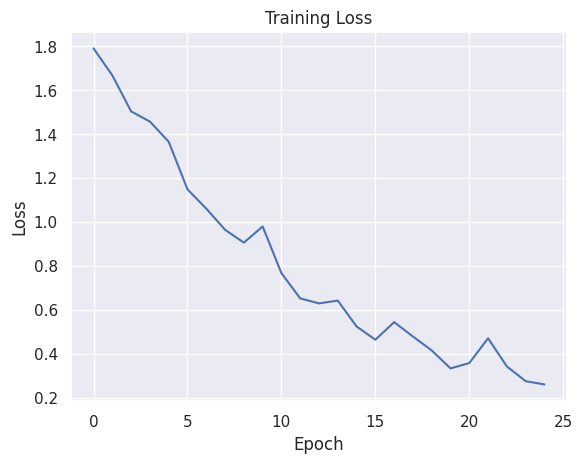

In [8]:
# plot the training loss
sns.set(style='darkgrid')
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [9]:
train_accs = [d.item() for d in train_accs]
test_accs = [d.item() for d in test_accs]

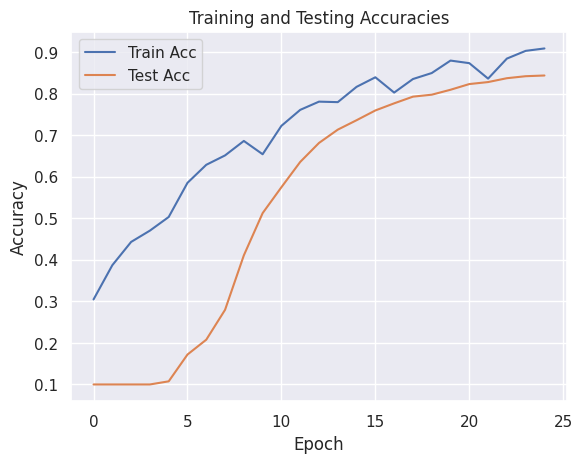

In [10]:
# plot the training and testing accuracies
sns.set(style='darkgrid')
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Training and Testing Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [11]:
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")
# Test the model
loss, acc = evaluate_model(global_model, test_loader, device,)
print(f'Loss: {loss}, Accuracy: {acc*100}%')
print_model_size(global_model)

# Measure inference latency
cpu_inference_latency = measure_inference_latency(model=global_model, device=cpu_device, input_size=(1,3,32,32), num_samples=100)
gpu_inference_latency = measure_inference_latency(model=global_model, device=cuda_device, input_size=(1,3,32,32), num_samples=100)
print("CPU Inference Latency: {:.2f} ms / sample".format(cpu_inference_latency * 1000))
print("CUDA Inference Latency: {:.2f} ms / sample".format(gpu_inference_latency * 1000))

Loss: 0.0, Accuracy: 84.3499984741211%
44.77 MB
CPU Inference Latency: 9.08 ms / sample
CUDA Inference Latency: 1.60 ms / sample


In [12]:
save_model(global_model, "saved_models", f'resnet_fedlern_{time_stamp()}.pth')